In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from ocsai.train import prepare_training_response, prepare_prompt, prepare_training_prompt, prepare_gpt_from_series
from pathlib import Path
import json
from tqdm.auto import tqdm
import openai
from collections import defaultdict
import tiktoken
import time
client = openai.OpenAI()

In [291]:
data = pd.read_csv('../data/ocsai-all.csv')
data_dir = Path('../data/training/gpt')
data_dir.mkdir(exist_ok=True, parents=True)

/var/folders/k2/vg86l2h54czgjfzlmd6fkz908bdx0t/T/ipykernel_42523/1825289779.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/ocsai-all.csv')


In [292]:
data.groupby(['language', 'type']).size()

language  type        
ara       uses              923
chi       uses            16589
dut       uses             7139
eng       completion       2797
          consequences     3195
          instances        4448
          metaphors        4341
          uses            24954
fre       uses             3400
ger       uses            13687
heb       uses              829
ita       uses             8597
pol       uses             7518
rus       uses             1863
spa       uses              783
dtype: int64

## Add Confidence Scores

- 50% of scores are confidence=3
- 25% of scores are confidence=2
- 25% of scores are confidence=1

>>> TO CONSIDER: THIS would tell people 25% of their data is suspect

**ADD more bins??**

In [342]:
# get quartile bins for data.rating_std
bins = data.rating_std.quantile([.25, .5, .75, 1]).round(2).values
bins[-1] = 5 # make the max bin something that wouldn't be hit
bin_labels = list(range(len(bins)-1,0, -1))
print("CONFIDENCE <-> RATING_STD BINS")
for i, lab in enumerate(bin_labels):
    print(f"Confidence {lab} is for stdev ranges {bins[i]}-{bins[i+1]}")
display(bins)
data['confidence'] = pd.cut(data.rating_std, bins,
                            include_lowest=True,
                            labels=bin_labels)
data[['rating_std', 'confidence']].sample(2)

array([0.  , 0.  , 0.58, 0.82, 3.54])

<AxesSubplot:>

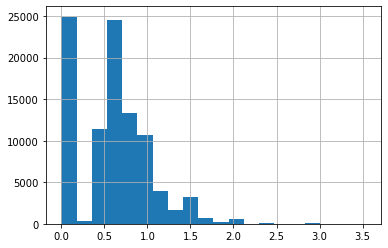

In [347]:
data.rating_std.hist(bins=20)

Different source, by confidence.

In [294]:
data.confidence = pd.to_numeric(data.confidence)
data[~data.confidence.isna()].groupby('src')['confidence'].aggregate(['mean', 'size']).sort_values('mean', ascending=False).query('size > 100').round(2).head(60)

,mean,size
src,,
multiaut_dutch1/multiaut_dutch2,2.78,194
multiaut_german1,2.76,4934
multiaut_italian2,2.75,5511
multiaut_polish1,2.73,5051
multiaut_italian1,2.71,3081
multiaut_dutch2,2.71,753
multiaut_russian1,2.68,1503
multiaut_german3,2.67,5929
snb17,2.67,1337


## Generic Prompt Format

The training prompts randomly mask parts of the full prompt, to encourage the model to get by without it.

The confidence is based on the standard deviation of the human ratings: imperfect, but aiming for at least a bit of signal about the reliability of the rating.

### Example Unmasked Prompt:

```
ACTION: TAG THE ORIGINALITY OF A RESPONSE TO A CREATIVITY TEST.
TASK: uses
PROMPT: علب الصفيح
TASK QUESTION: ما هو الاستخدام المفاجئ لـ علب الصفيح؟
LANGUAGE: ara
RESPONSE: `آلات حادة`

## Details
SCALE: 1-5, where 1 is `not original at all` and 5 is `extremely original`
FORMAT: Return in the format of newline-separated `KEY:value` pairs, with the following fields:
- `SCORE`: An originality score, 1-5
- `CONFIDENCE`: A measure of confidence in the score, 1-3, or None.
- `FLAGS`: A comma-separated list with content flags, such as: 'nonsense', 'violent', 'not practical'
```

### Example Masked Prompt

```
TASK: uses
PROMPT: علب الصفيح
RESPONSE: `آلات حادة`
```

### Masking probabilities

`task_exclude_prob=0.5, task_type_exclude_prob=0.3, prompt_exclude_prob=0, language_exclude_prob=0.5, question_exclude_prob=0.3, detail_exclude_prob=0.8`

### Example Response

```
SCORE:2.0
CONFIDENCE:1
```

In [193]:
for i in range(3):
    a = data.sample(frac=1).iloc[i]
    p = prepare_training_prompt(a['prompt'], a['response'], a['type'], a['question'], a['language'],)
    print(p)
    print('----')
    r = prepare_training_response(a['target'], a['confidence'])

ACTION: TAG THE ORIGINALITY OF A RESPONSE TO A CREATIVITY TEST.
PROMPT: messy room
TASK QUESTION: Think of the messiest room that you’ve ever had to live in. What was it like to live there?
LANGUAGE: eng
RESPONSE: `That room was like the inside of a child's mind`

## Details
SCALE: 1-5, where 1 is `not original at all` and 5 is `extremely original`
FORMAT: Return in the format of newline-separated `KEY:value` pairs, with the following fields:
- `SCORE`: An originality score, 1-5
- `CONFIDENCE`: A measure of confidence in the score, 1-3, or None.
----
PROMPT: cegła
TASK QUESTION: Jakie jest zaskakujące zastosowanie dla CEGŁY?
LANGUAGE: pol
RESPONSE: `brodzik`
----
TASK: uses
PROMPT: Mülltüte
TASK QUESTION: Was ist eine überraschende Verwendung für eine MÜLLTÜTE?
LANGUAGE: ger
RESPONSE: `Decke`
----


## Create Prompts For GPT

Here is the expected new ChatCompletions format, via https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset:

```
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}
```

There's a system message, user message, then an assistant message. These are saved in a JSONL file.

Example, using `prepare_gpt_from_series`:

In [194]:
data.sample(1).apply(prepare_gpt_from_series, axis=1).tolist()

[{'messages': [{'role': 'system',
    'content': 'You are a creativity judge, scoring tests of originality.'},
   {'role': 'user',
    'content': 'TASK: uses\nPROMPT: frozen\nLANGUAGE: eng\nRESPONSE: `snowman`'},
   {'role': 'assistant', 'content': 'SCORE: 2.4\nCONFIDENCE: 3'}]}]

Export test/validation/train data, as well as a small set for testing training.

In [195]:
smalldata = data.sample(2000, random_state=42)
smalldata.to_csv(data_dir / 'smalldata.csv', index=False)

for df, suffix in [(smalldata, 'small'), (data, 'full')]:
    for splitset in ['default_split']:
        for split in ['train', 'val', 'test']:
            subset = df[df['default_split'] == split]
            # seed is not necessary here
            jsonl = subset.apply(prepare_gpt_from_series, axis=1).tolist()
            fname = data_dir / f"{splitset}_{split}_{suffix}.jsonl"
            with open(fname, mode='w') as f:
                # write jsonlines file
                for j in jsonl:
                    f.write(json.dumps(j))
                    f.write('\n')

#### Validate Data Format

via https://cookbook.openai.com/examples/chat_finetuning_data_prep

Focus on the biggest file - the full training data.

In [196]:
fname = data_dir / 'default_split_train_full.jsonl'

# Load the dataset
with open(fname, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 80770
First example:
{'role': 'system', 'content': 'You are a creativity judge, scoring tests of originality.'}
{'role': 'user', 'content': 'TASK: uses\nPROMPT: علب الصفيح\nLANGUAGE: ara\nRESPONSE: `آلات حادة`'}
{'role': 'assistant', 'content': 'SCORE: 2.0'}


In [197]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [199]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")



In [200]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 49, 311
mean / median: 97.1770335520614, 84.0
p5 / p95: 64.0, 165.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 6, 13
mean / median: 12.640336758697536, 13.0
p5 / p95: 13.0, 13.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


In [201]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Training dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Training dataset has ~7848989 tokens that will be charged for during training
By default, you'll train for 1 epochs on this dataset
By default, you'll be charged for ~7848989 tokens


In [202]:
base_cost = 0.0080 # per 1K
est_cost_train = base_cost * n_epochs * n_billing_tokens_in_dataset / 1000
print(f"Estimated cost for training {n_epochs} epoch is ${est_cost_train:.2f}")
print(f"Est with test/val: ${est_cost_train/.8:.2f}")
print(f"Est for {n_epochs*3} epochs: ${3*est_cost_train/.8:.2f}")

Estimated cost for training 1 epoch is $62.79
Est with test/val: $78.49
Est for 3 epochs: $235.47


## Upload Train Data to GPT

In [205]:
#@markdown Upload training files or retrieve already-trained files from OpenAI
sid = dict()

def upload_or_load(fname):
    fname = Path(fname)
    existing_files = [file for file in client.files.list() if file.filename == fname.name]
    if len(existing_files):
        print(f"Using already uploaded file named {fname.name}. If this was unintended, delete the server one.")
        return existing_files[0].id
    else:
        print("Uploading", fname)
        with open(fname, mode='rb') as f:
            results = client.files.create(
                file=f,
                purpose="fine-tune"
                )
        return results.id

for fname in tqdm(data_dir.glob("*jsonl")):
    sid[fname.name] = upload_or_load(fname)

# to delete everything:
# [client.files.delete(fid) for fid in sid.values()]
    
print("files:", sid.keys())

0it [00:00, ?it/s]

Uploading ../data/training/gpt/default_split_val_small.jsonl
Uploading ../data/training/gpt/default_split_train_full.jsonl
Uploading ../data/training/gpt/default_split_test_full.jsonl
Uploading ../data/training/gpt/default_split_val_full.jsonl
Uploading ../data/training/gpt/default_split_train_small.jsonl
Uploading ../data/training/gpt/default_split_test_small.jsonl
files: dict_keys(['default_split_val_small.jsonl', 'default_split_train_full.jsonl', 'default_split_test_full.jsonl', 'default_split_val_full.jsonl', 'default_split_train_small.jsonl', 'default_split_test_small.jsonl'])


## Start Train

In [206]:
set = 'full' # `small`` or `full``; small is a 1000 row subset to ensure everything works
suffix = f'ocsai-{set}-1-24'

Start training. Can't stop after this .. doublecheck that there's enough credit left on your account!

*future note: validation may be unnecessary. At the costs involved, it's not likely that you're tinkering much.*

In [207]:
model = client.fine_tuning.jobs.create(
  training_file=sid[f'default_split_train_{set}.jsonl'],
  validation_file=sid[f'default_split_val_{set}.jsonl'],
  suffix = suffix,
  model="gpt-3.5-turbo-1106"
)

# for reference: TO DELETE MODEL
#client.models.delete('ft:gpt-3.5-turbo-1106:peter-organisciak:ocsai-small-1-24:8cfMjxJN')

In [208]:
print("Hyper parameters", client.fine_tuning.jobs.retrieve(model.id).hyperparameters)

Hyper parameters Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto')


In [219]:
from wandb.integration.openai.fine_tuning import WandbLogger
WandbLogger.sync(fine_tune_job_id=model.id)

wandb: Retrieving fine-tune job...
wandb: WARNING Fine-tune ftjob-5Pbn7CQPO8u3z5SeNuq9IXSB has already been logged successfully at https://wandb.ai/massive-texts/OpenAI-Fine-Tune/runs/ftjob-5Pbn7CQPO8u3z5SeNuq9IXSB. Use `overwrite=True` if you want to overwrite previous run


In [218]:
# check in every few minutes to see training status
while True:
    status = client.fine_tuning.jobs.retrieve(model.id)
    print(status.status)
    if status.status not in ['running', 'pending', 'validating_files']:
        break
    if status.status == 'running':
        time.sleep(60)
    elif status.status in ['pending', 'validating_files']:
        print(status)
        time.sleep(5*60)
    else:
        break
status
    

succeeded


FineTuningJob(id='ftjob-5Pbn7CQPO8u3z5SeNuq9IXSB', created_at=1704319430, error=None, fine_tuned_model='ft:gpt-3.5-turbo-1106:peter-organisciak:ocsai-full-1-24:8d5RLryO', finished_at=1704326395, hyperparameters=Hyperparameters(n_epochs=1, batch_size=53, learning_rate_multiplier=2), model='gpt-3.5-turbo-1106', object='fine_tuning.job', organization_id='org-48rfjyoSnZfLJWOte33sjuqL', result_files=['file-Iq1Q3AeeXKStpPV4rKBJx9XI'], status='succeeded', trained_tokens=7687449, training_file='file-gTx9PdkFq4aaptjlRfoCptL6', validation_file='file-TB49njVn1PWGB5SHbH869Xc9')

## Test Fine-tune

In [2]:
models = {
    "small": "ft:gpt-3.5-turbo-1106:peter-organisciak:ocsai-small-1-24:8cmALwWt",
    "full": "ft:gpt-3.5-turbo-1106:peter-organisciak:ocsai-full-1-24:8d5RLryO"
}

For here, just evaluate on data that has been processed identically to the training data (with the same masking). Other conditions can be measured elsewhere.

In [3]:
from ocsai.train import GPT_SYS_MSG
from ocsai.inference import GPT_Chat_Scorer
scorer = GPT_Chat_Scorer(model_dict=models, cache='../data/test_cache')

In [353]:
from ocsai.utils import upgrade_cache
upgrade_cache('../data/test_cache', chunksize=10000)

checking ids on new files: 100%|██████████| 2/2 [00:00<00:00, 114.81it/s]

Checking that all ids are preserved
Original ids: 16908
New ids: 16908
All ids preserved, deleting old files


In [4]:
#smalldata = pd.read_csv(data_dir / 'smalldata.csv')
#testdata = smalldata[smalldata.default_split == 'test'].copy()
#testdata = data[data.default_split == 'test'].sample(400, random_state=42).copy()

In [358]:
all_scored['score'] = pd.to_numeric(all_scored['score'], errors='raise')
all_scored['predict_confidence'] = pd.to_numeric(all_scored['predict_confidence'], errors='raise')

print("overall corr", all_scored[['target', 'score']].corr().round(2).iloc[0,1])

print("How well does predicted confidence correlate with actual confidence?")
print(all_scored[['confidence', 'predict_confidence']].corr().round(2).iloc[0,1])

print("Correlation by predicted confidence")
all_scored.groupby('predict_confidence')[['target', 'score']].corr().iloc[::2, 1].round(2)

# correlation of target and score column
from scipy.stats import pearsonr
def stats(x):
    corr, p_val, conf_corr = np.nan, np.nan, np.nan
    nans = x[['target', 'score']].isna().any(axis=1)
    if (~nans).sum() > 10:
        corr, p_val = pearsonr(x[~nans]['target'], x[~nans]['score'])

    nans = x[['confidence', 'predict_confidence']].isna().any(axis=1)
    if (~nans).sum() > 10:
        conf_corr = pearsonr(x[~nans]['confidence'], x[~nans]['predict_confidence'])[0]

    return pd.Series({
        'n': len(x),
        'corr': np.round(corr, 2),
        'p_val': np.round(p_val, 3),
        'conf_corr': np.round(conf_corr, 2),
        'rmse': np.round(np.sqrt(np.mean((x['target'] - x['score'])**2)), 3)
    })
x = all_scored.groupby(['language', 'type']).apply(stats)
x[~x['corr'].isna()].sort_values('corr')

overall corr 0.56
How well does predicted confidence correlate with actual confidence?
0.12
Correlation by predicted confidence


,,n,corr,p_val,conf_corr,rmse
language,type,,,,,
pol,uses,1000.0,0.56,0.0,0.12,0.54


In [300]:
all_scored[all_scored['language'] == 'ara'][['target', 'score']].corr()

,target,score
target,1.000000,0.285911
score,0.285911,1.000000


In [301]:
all_scored.groupby(['language']).apply(stats)

,n,corr,p_val,conf_corr,rmse
language,,,,,
ara,148.0,0.29,0.0,NaN,1.145
chi,252.0,0.47,0.0,-0.04,0.418
